In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2


In [2]:
root = '/home/yons/data/jieyi/automatic_bridge_detection'
import glob
tif_paths = glob.glob(root+'/*.tif')
print(len(tif_paths), tif_paths[0])


2000 /home/yons/data/jieyi/automatic_bridge_detection/1092.tif


(668, 668, 3)
<class 'numpy.ndarray'>
uint8


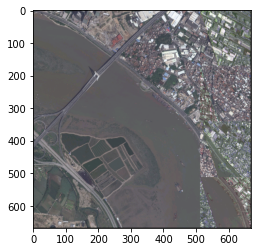

In [4]:
from libtiff import TIFF

img = TIFF.open(tif_paths[0], mode='r').read_image()# [:, :, [2, 1, 0]]
print(img.shape)
print(type(img))
print(img.dtype)
plt.imshow(img)

# 大致看了都是668,668 个别1001, 1001

# single file test

250 257 323 326


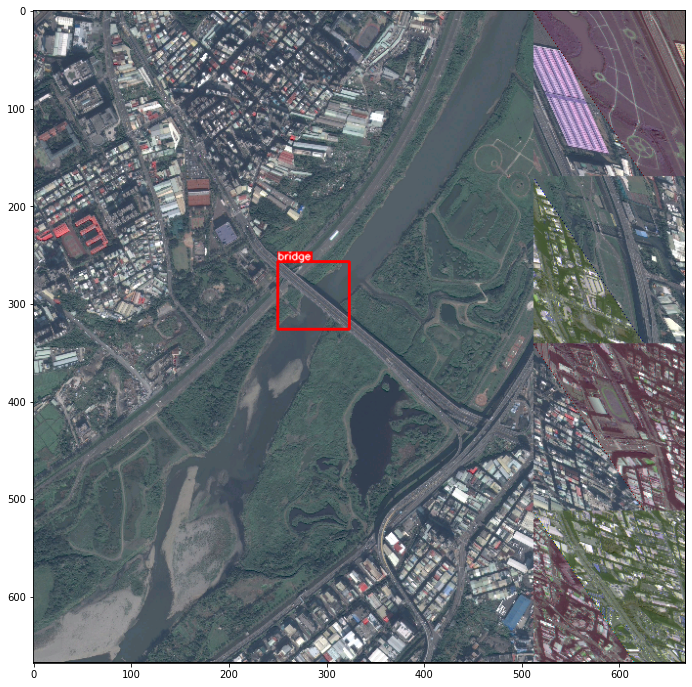

In [36]:
def get(root, name):
    vars = root.findall(name)
    return vars

def get_and_check(root, name, length):
    vars = root.findall(name)
    if len(vars) == 0:
        raise ValueError("Can not find %s in %s." % (name, root.tag))
    if length > 0 and len(vars) != length:
        raise ValueError(
            "The size of %s is supposed to be %d, but is %d."
            % (name, length, len(vars))
        )
    if length == 1:
        vars = vars[0]
    return vars
import xml.etree.ElementTree as ET

idx = '52'
xml_file = '/home/yons/data/jieyi/automatic_bridge_detection/{}.xml'.format(idx)
tif_path = '/home/yons/data/jieyi/automatic_bridge_detection/{}.tif'.format(idx)
img = TIFF.open(tif_path, mode='r').read_image()
tree = ET.parse(xml_file)
root = tree.getroot()
objects = get_and_check(root, "objects", 1)
bboxes = []
for obj in get(objects, "object"):
    points = get_and_check(obj, 'points', 1)
    pos_list = []
    for point in get_and_check(points, 'point', 5):
        x, y = point.text.split(',')
        x, y = float(x), float(y)
        pos_list.append([x, y])
    pos_npy = np.array(pos_list)
    xmin, xmax, ymin, ymax = np.min(pos_npy[:,0]), np.max(pos_npy[:,0]), np.min(pos_npy[:,1]), np.max(pos_npy[:,1])
    bbox = [xmin, ymin, xmax, ymax]
    bboxes.append(bbox)
    
    
import cv2 
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    bbox = [int(x) for x in bbox]
    x_min, y_min, x_max, y_max = bbox
    print(x_min, y_min, x_max, y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(img, bboxes):
    for idx, bbox in enumerate(bboxes):
        img = visualize_bbox(img, bbox, 'bridge')
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    
visualize(img, bboxes)

# all to json

In [51]:


root = '/home/yons/data/jieyi/automatic_bridge_detection'
import glob
from PIL import Image
from tqdm import tqdm

tif_paths = glob.glob(root+'/*.tif')
from random import shuffle
import random
random.seed(20)
shuffle(tif_paths)

def xml2coco(tif_paths, json_path):
    json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}
    cat = {"supercategory": "none", "id": 1, "name": 'bridge'}
    json_dict["categories"].append(cat)
    image_id = 0
    bnd_id = 1
    for tif_path in tqdm(tif_paths):
        xml_path = tif_path.replace('tif', 'xml')
        img = Image.open(tif_path)
        width, height = img.size
        filename = os.path.basename(tif_path)
        image_id = image_id + 1
        image = {
            "file_name": filename,
            "height": height,
            "width": width,
            "id": image_id,
        }
        json_dict["images"].append(image)

        tree = ET.parse(xml_path)
        root = tree.getroot()
        objects = get_and_check(root, "objects", 1)
        for obj in get(objects, "object"):
            points = get_and_check(obj, 'points', 1)
            pos_list = []
            for point in get_and_check(points, 'point', 5):
                x, y = point.text.split(',')
                x, y = float(x), float(y)
                pos_list.append([x, y])
            pos_npy = np.array(pos_list)
            xmin, xmax, ymin, ymax = np.min(pos_npy[:,0]), np.max(pos_npy[:,0]), np.min(pos_npy[:,1]), np.max(pos_npy[:,1])
            assert xmax > xmin
            assert ymax > ymin
            o_width = abs(xmax - xmin)
            o_height = abs(ymax - ymin)
            category_id = 1
            ann = {
                "area": o_width * o_height,
                "iscrowd": 0,
                "image_id": image_id,
                "bbox": [xmin, ymin, o_width, o_height],
                "category_id": category_id,
                "id": bnd_id,
                "ignore": 0,
                "segmentation": [[xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax]], # just for maskrcnn
            }
            json_dict["annotations"].append(ann)
            bnd_id = bnd_id + 1
    import json 
    os.makedirs(os.path.dirname(json_path), exist_ok=True)
    json_fp = open(json_path, "w")
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()

n = int(0.9 * len(tif_paths))
json_path = '/home/yons/data/jieyi/automatic_bridge_detection/instances_trainval2017.json'
xml2coco(tif_paths, json_path)

json_path = '/home/yons/data/jieyi/automatic_bridge_detection/instances_train2017.json'
xml2coco(tif_paths[:n], json_path)

json_path = '/home/yons/data/jieyi/automatic_bridge_detection/instances_val2017.json'
xml2coco(tif_paths[n:], json_path)

100%|██████████| 200/200 [00:00<00:00, 2136.64it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
200
[[250.3095, 257.1751, 73.17339999999996, 68.89859999999999, 1]]


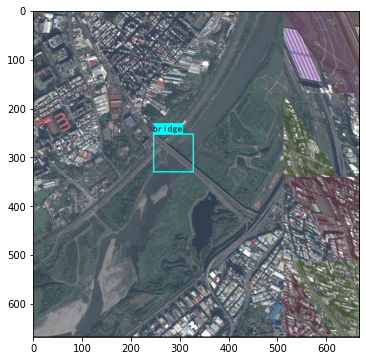

In [52]:
from pycocotools.coco import COCO
json_path = '/home/yons/data/jieyi/automatic_bridge_detection/instances_val2017.json'
coco=COCO(json_path)

imgIds = coco.getImgIds()
print(len(imgIds))
img_id = imgIds[np.random.choice(len(imgIds))]
img_id = 5
img = coco.loadImgs(img_id)[0]
image_id = img['file_name'].split('.')[0]
save_image_dir = '/home/yons/data/jieyi/automatic_bridge_detection'
image_path = os.path.join(save_image_dir, '{}.tif'.format(image_id))
annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
anns = coco.loadAnns(annIds)
bboxes = [[*ann['bbox'], ann['category_id']] for ann in anns]
print(bboxes)
from myutils import vis_coco
vis_coco(image_path, bboxes, coco)